In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm

from uncoditioned_epsilon_theta_networks import Unconditioned_Simple_MLP, Unconditioned_MLP, Unconditioned_TimeEmbedding_MLP

(10000, 2)


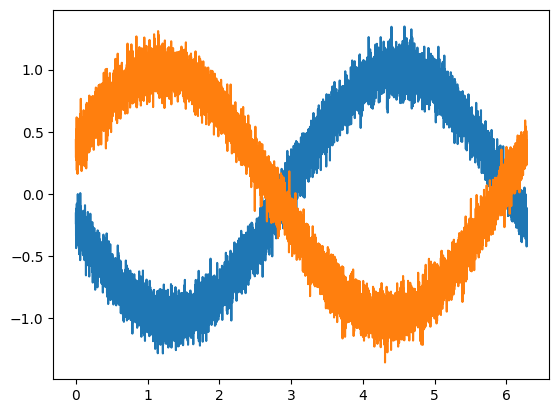

In [2]:
def generate_distorted_sine_data(num_variables=1, length=10000, noise_level=0.1, frequency=1.0, amplitude=1.0):
    time = np.linspace(0, 2 * np.pi, length)
    data = {}

    for i in range(num_variables):
        # Generate a sine wave with specified frequency and amplitude
        sine_wave = amplitude * np.sin(frequency * time + np.random.uniform(0, 2 * np.pi))
        # Add random noise to distort the sine wave
        noise = np.random.normal(0, noise_level, length)
        distorted_wave = sine_wave + noise
        data[f"Variable_{i+1}"] = distorted_wave

    return pd.DataFrame(data, index=time)

data = generate_distorted_sine_data(num_variables=2)
print(data.shape)
plt.plot(data)

In [3]:
class Diffusion:
    def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.total_steps = total_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = self.linear_noise_schedule()
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(device)
                
    def linear_noise_schedule(self):
        scale = 1000 / self.total_steps
        beta_start = scale * self.beta_start
        beta_end = scale * self.beta_end
        betas = torch.linspace(beta_start, beta_end, self.total_steps)
        
        return betas
    
    def forward_process(self, x, t):
        # print(f"Device x:{x.device}")
        # print(f"Device alphas_cumprod:{self.alphas_cumprod.device}")
        sqrt_alpha_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None]
        sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alphas_cumprod[t])[:, None]
        
        noise = torch.randn_like(x)
        
        noisy_x = sqrt_alpha_cumprod * x + sqrt_one_minus_alpha_cumprod * noise
        
        return noisy_x, noise
    
    def reverse_process(self, epsilon_theta, x_t, t):
        betas = self.betas.to(self.device)
        alphas = self.alphas.to(self.device)
        sqrt_alpha_t = torch.sqrt(alphas[t])[:, None]
        betas_t = betas[t][:, None]
        sqrt_one_minus_alpha_cumpord_t = torch.sqrt(1 - self.alphas_cumprod[t])[:, None]
        epsilon_t = torch.sqrt(betas[t][:, None])
        
        random_noise = torch.randn_like(x_t)
        random_noise[t == 0] = 0.0
        
        model_mean = ((1 / sqrt_alpha_t) * (x_t - (betas_t * epsilon_theta / sqrt_one_minus_alpha_cumpord_t)))
        prev_x_t = model_mean + (epsilon_t * random_noise)
        
        return prev_x_t
        
    def sample_timestep(self, num_time_steps):
        t = torch.randint(low=1, high=self.total_steps, size=(num_time_steps,), device=self.device)
        return t

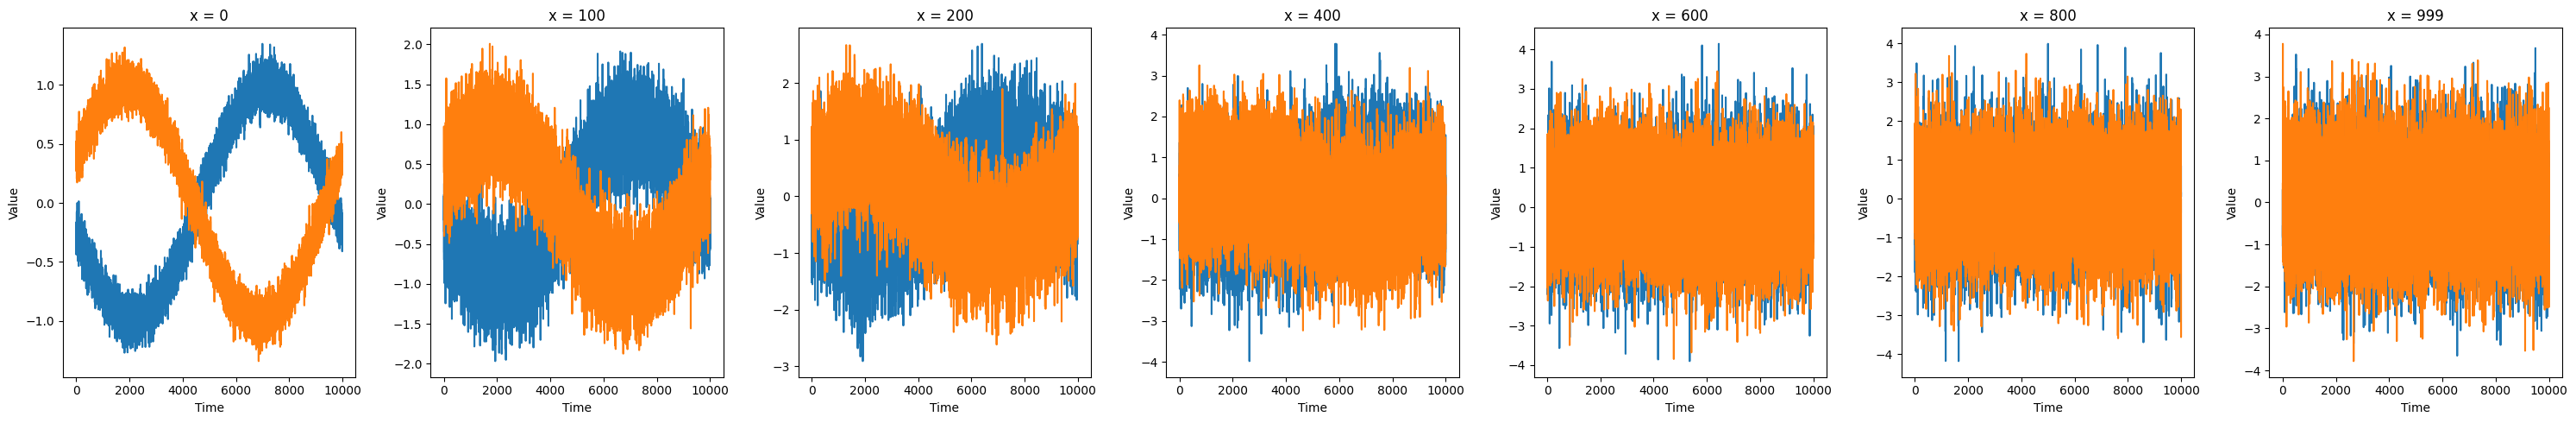

In [4]:
### Viz forward process
diff = Diffusion()
tensor_data = torch.Tensor(data.values)

x_values = [0, 100, 200, 400, 600, 800, 999]
fig, axes = plt.subplots(1, len(x_values), figsize=(30, 5))
for i, x in enumerate(x_values):
    noisy_ts, noise = diff.forward_process(tensor_data, [x])
    axes[i].plot(noisy_ts)
    axes[i].set_title(f"x = {x}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Value")

plt.tight_layout()
plt.show()

In [5]:
batch_size = 512
epochs = 500
device = "cuda:0"
learning_rate = 1e-4

dataloader = DataLoader(
    dataset=tensor_data,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)

batch = next(iter(dataloader))
print(batch.shape)


torch.Size([512, 2])


In [9]:
#epsilon_theta = Unconditioned_Simple_MLP(1, 256)
#epsilon_theta = Unconditioned_MLP(1, [1024, 1024, 1024, 1024, 1024])
epsilon_theta = Unconditioned_TimeEmbedding_MLP(2, [1024, 1024, 1024, 1024])

In [10]:
diffuser = Diffusion(device=device)

optimizer = optim.Adam(epsilon_theta.parameters(), lr=learning_rate)
loss_fnc = nn.MSELoss()

In [11]:
train_epoch_losses = []

epsilon_theta = epsilon_theta.to(device)
epsilon_theta.train()

pbar = tqdm(iterable=range(epochs), position=0, leave=True)

for epoch in pbar:
    batch_losses = []
    
    for batch in dataloader:
        batch = batch.to(device)
        
        timesteps = diffuser.sample_timestep(batch.shape[0])

        #forward process
        batch_noise_t, noise_t = diffuser.forward_process(batch, timesteps)
        
        #predict noise
        #predicted_noise = epsilon_theta(batch_noise_t)
        predicted_noise = epsilon_theta(batch_noise_t, timesteps)
        
        batch_loss = loss_fnc(input=noise_t, target=predicted_noise)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        batch_losses.append(batch_loss.detach().cpu().numpy())
        
    batch_losses_mean = np.mean(np.array(batch_losses))
    train_epoch_losses.append(batch_losses_mean)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {batch_losses_mean:.4f}")

  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:00<01:06,  7.43it/s]

Epoch 0, Loss: 0.9180


  3%|▎         | 13/500 [00:01<00:40, 12.11it/s]

Epoch 10, Loss: 0.7982


  5%|▍         | 23/500 [00:02<00:36, 13.24it/s]

Epoch 20, Loss: 0.7782


  7%|▋         | 33/500 [00:02<00:35, 13.22it/s]

Epoch 30, Loss: 0.7920


  9%|▊         | 43/500 [00:03<00:33, 13.74it/s]

Epoch 40, Loss: 0.7796


 11%|█         | 53/500 [00:04<00:32, 13.87it/s]

Epoch 50, Loss: 0.7911


 13%|█▎        | 63/500 [00:04<00:30, 14.10it/s]

Epoch 60, Loss: 0.7915


 15%|█▍        | 73/500 [00:05<00:30, 14.13it/s]

Epoch 70, Loss: 0.7889


 17%|█▋        | 83/500 [00:06<00:30, 13.77it/s]

Epoch 80, Loss: 0.7891


 19%|█▊        | 93/500 [00:07<00:29, 13.60it/s]

Epoch 90, Loss: 0.7735


 21%|██        | 103/500 [00:07<00:26, 15.10it/s]

Epoch 100, Loss: 0.7847


 23%|██▎       | 113/500 [00:08<00:25, 15.24it/s]

Epoch 110, Loss: 0.7835


 25%|██▍       | 123/500 [00:09<00:24, 15.44it/s]

Epoch 120, Loss: 0.7939


 27%|██▋       | 133/500 [00:09<00:23, 15.69it/s]

Epoch 130, Loss: 0.7883


 29%|██▊       | 143/500 [00:10<00:22, 15.83it/s]

Epoch 140, Loss: 0.7879


 31%|███       | 153/500 [00:10<00:22, 15.76it/s]

Epoch 150, Loss: 0.7867


 33%|███▎      | 163/500 [00:11<00:21, 15.70it/s]

Epoch 160, Loss: 0.7949


 35%|███▍      | 173/500 [00:12<00:20, 15.74it/s]

Epoch 170, Loss: 0.7948


 37%|███▋      | 183/500 [00:12<00:20, 15.72it/s]

Epoch 180, Loss: 0.7830


 39%|███▊      | 193/500 [00:13<00:19, 15.53it/s]

Epoch 190, Loss: 0.7727


 41%|████      | 203/500 [00:14<00:18, 15.83it/s]

Epoch 200, Loss: 0.7859


 43%|████▎     | 213/500 [00:14<00:18, 15.88it/s]

Epoch 210, Loss: 0.7933


 45%|████▍     | 223/500 [00:15<00:17, 15.86it/s]

Epoch 220, Loss: 0.7905


 47%|████▋     | 233/500 [00:16<00:17, 15.60it/s]

Epoch 230, Loss: 0.7904


 49%|████▊     | 243/500 [00:16<00:16, 15.37it/s]

Epoch 240, Loss: 0.7901


 51%|█████     | 253/500 [00:17<00:16, 14.90it/s]

Epoch 250, Loss: 0.8008


 53%|█████▎    | 263/500 [00:18<00:16, 14.70it/s]

Epoch 260, Loss: 0.7883


 55%|█████▍    | 273/500 [00:18<00:15, 15.09it/s]

Epoch 270, Loss: 0.7881


 57%|█████▋    | 283/500 [00:19<00:14, 15.15it/s]

Epoch 280, Loss: 0.7922


 59%|█████▊    | 293/500 [00:20<00:14, 14.77it/s]

Epoch 290, Loss: 0.7818


 61%|██████    | 303/500 [00:20<00:12, 15.47it/s]

Epoch 300, Loss: 0.7888


 63%|██████▎   | 313/500 [00:21<00:12, 15.01it/s]

Epoch 310, Loss: 0.7968


 65%|██████▍   | 323/500 [00:22<00:11, 14.83it/s]

Epoch 320, Loss: 0.7901


 67%|██████▋   | 333/500 [00:22<00:10, 15.63it/s]

Epoch 330, Loss: 0.7845


 69%|██████▊   | 343/500 [00:23<00:10, 15.39it/s]

Epoch 340, Loss: 0.7893


 71%|███████   | 353/500 [00:23<00:09, 15.63it/s]

Epoch 350, Loss: 0.7812


 73%|███████▎  | 363/500 [00:24<00:08, 15.35it/s]

Epoch 360, Loss: 0.7831


 75%|███████▍  | 373/500 [00:25<00:08, 15.47it/s]

Epoch 370, Loss: 0.7941


 77%|███████▋  | 383/500 [00:25<00:07, 15.31it/s]

Epoch 380, Loss: 0.7939


 79%|███████▊  | 393/500 [00:26<00:06, 15.49it/s]

Epoch 390, Loss: 0.8000


 81%|████████  | 403/500 [00:27<00:06, 14.58it/s]

Epoch 400, Loss: 0.7869


 83%|████████▎ | 413/500 [00:27<00:06, 14.01it/s]

Epoch 410, Loss: 0.7939


 85%|████████▍ | 423/500 [00:28<00:05, 14.07it/s]

Epoch 420, Loss: 0.7894


 87%|████████▋ | 433/500 [00:29<00:04, 14.20it/s]

Epoch 430, Loss: 0.7909


 89%|████████▊ | 443/500 [00:30<00:03, 15.03it/s]

Epoch 440, Loss: 0.7658


 91%|█████████ | 453/500 [00:30<00:03, 14.94it/s]

Epoch 450, Loss: 0.7778


 93%|█████████▎| 463/500 [00:31<00:02, 15.12it/s]

Epoch 460, Loss: 0.7795


 95%|█████████▍| 473/500 [00:32<00:01, 15.26it/s]

Epoch 470, Loss: 0.7974


 97%|█████████▋| 483/500 [00:32<00:01, 15.14it/s]

Epoch 480, Loss: 0.7863


 99%|█████████▊| 493/500 [00:33<00:00, 15.06it/s]

Epoch 490, Loss: 0.7846


100%|██████████| 500/500 [00:33<00:00, 14.78it/s]


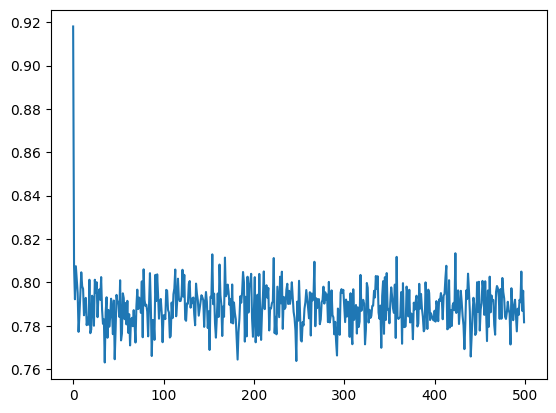

In [12]:
plt.plot(train_epoch_losses)

In [13]:
@torch.no_grad()
def generate_new_samples(epsilon_theta, diffuser, features, num_samples, diffusion_steps, device):
    random_noise_samples = torch.randn((num_samples, features)).to(device)
    
    pbar = tqdm(iterable=reversed(range(0, diffusion_steps)))
    for i in pbar:
        pbar.set_description(f"SAMPLING STEP: {i:4d}")
        
        t = torch.full((num_samples,), i, dtype=torch.long).to(device)
        # print(f"Device random_noise_samples:{random_noise_samples.device}")
        # print(f"Device t:{t.device}")
        # print(f"Device model:{diffuser.device}")
        predicted_noise = epsilon_theta(random_noise_samples.float(), t)
        z_norm = diffuser.reverse_process(predicted_noise, random_noise_samples, t)
        
    return z_norm
    

SAMPLING STEP:    0: : 1000it [00:02, 483.38it/s]


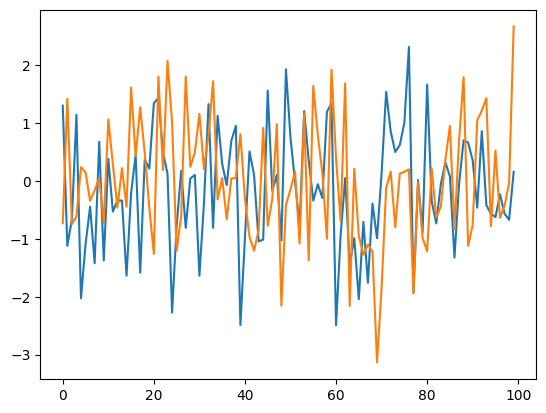

In [14]:
new_data = generate_new_samples(epsilon_theta, diffuser, features=2, num_samples=100, diffusion_steps=1000, device=device)
new_data = new_data.to("cpu")
plt.plot(new_data)